In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import DataParallel 

import esm 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.patches as patches


from tqdm import tqdm
from scipy import stats
import gc

from model.affinity_pred_model import AffinityPredictor 
from model.utilities import get_model 
from model.create_dataset import convert, idx2token   


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = get_model() 
model = model.to(device)

In [4]:
seed_scFv = {
    '14': 'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSSGGGGSGGGGSGGGGSDVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKAGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK',
    '91': 'EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSGISWNSGSIGYADSVKGRFTISRDNAENSLYLQMNSLRAEDTALYYCAKVGRGGGYFDYWGQGTLVTVSSGGGGSGGGGSGGGGSQAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPPQYLLRYKSDSDKQQGSGVPSRFSGSKDASANAGILLISGLQSEDEADYYCMIWHSSAWVFGGGTKLTVL',
    '95': 'EVQLVESGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLEWMGWISAYNGNTNYAQKLQGRVTMTTDTSTSTAYMELRSLRSDDTAVYYCARVGRGVIDHWGQGTLVTVSSGGGGSGGGGSGGGGSSSELTQDPAVSVALGQTVRITCEGDSLRYYYANWYQQKPGQAPILVIYGKNNRPSGIADRFSGSNSGDTSSLIITGAQAEDEADYYCSSRDSSGFQVFFGAGTKLTVL'
    }

In [5]:
input_sequence = "EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSSGGGGSGGGGSGGGGSDVVMTQSPESLAVSLGERATISCKSGWSVLYESRNKNSVAWYQQKAGQPPKLLIYAASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK"


In [8]:
def get_contact_for_sequence(model, input_sequence):
    with torch.no_grad():
        toks = convert(input_sequence)
        #print(toks) 
        seq = torch.unsqueeze(torch.tensor(toks),0).to(device) 
        #print('Sequence tokens length =', seq.shape) 
        outputs_batch =  model.encoder(seq, repr_layers=[33], return_contacts=True) 

    AAs = [idx2token(idx) for idx in toks][1:-1]
    #print(len(AAs), AAs)
    contacts = outputs_batch['contacts'].to('cpu').numpy()
    #print(contacts.shape)
    combined_contacts = contacts[0] 

    HC_length = input_sequence.find('GGGGSGGGGSGGGGS')
    LC_length = len(input_sequence)-(HC_length)-15

    fig, ax = plt.subplots(1,2, figsize=(40, 20))  
    HC_last_idx = HC_length 
    left_top_contacts = combined_contacts[:HC_last_idx, :HC_last_idx]
    labels = AAs[:HC_last_idx] 
    x_labels = [labels[i]+str(i+1) for i in range(len(labels))]
    im = ax[0].imshow(left_top_contacts, cmap='Blues', aspect='auto', 
                extent=[-0.5, len(labels) - 0.5, -0.5, len(labels) - 0.5], origin="lower")
    ax[0].set_xticks(range(HC_last_idx))
    ax[0].set_yticks(range(HC_last_idx))
    ax[0].set_xticklabels(x_labels, rotation=90, ha="center", fontsize=10)  # Rotate x-axis labels for better readability
    ax[0].set_yticklabels(x_labels, fontsize=10)
    #cbar = ax[0].figure.colorbar(im, ax=ax)
    ax[0].set_title('Heavy Chain contacts', fontsize=18)


    LC_first_idx = HC_length + 15 
    LC_contacts = combined_contacts[LC_first_idx:LC_first_idx+LC_length, LC_first_idx:LC_first_idx+LC_length]
    labels = AAs[LC_first_idx:LC_first_idx+LC_length] 
    x_labels = [labels[i]+str(i+1) for i in range(len(labels))]
    im = ax[1].imshow(LC_contacts, cmap='Blues', aspect='auto', 
                extent=[-0.5, len(labels) - 0.5, -0.5, len(labels) - 0.5], origin="lower")
    ax[1].set_xticks(range(LC_length))
    ax[1].set_yticks(range(LC_length))
    ax[1].set_xticklabels(x_labels, rotation=90, ha="center", fontsize=10)  # Rotate x-axis labels for better readability
    ax[1].set_yticklabels(x_labels, fontsize=10)
    ax[1].set_title('Ligth Chain contacts', fontsize=18)
    #plt.colorbar(im, ax=ax)

    plt.tight_layout() 
    plt.show() 



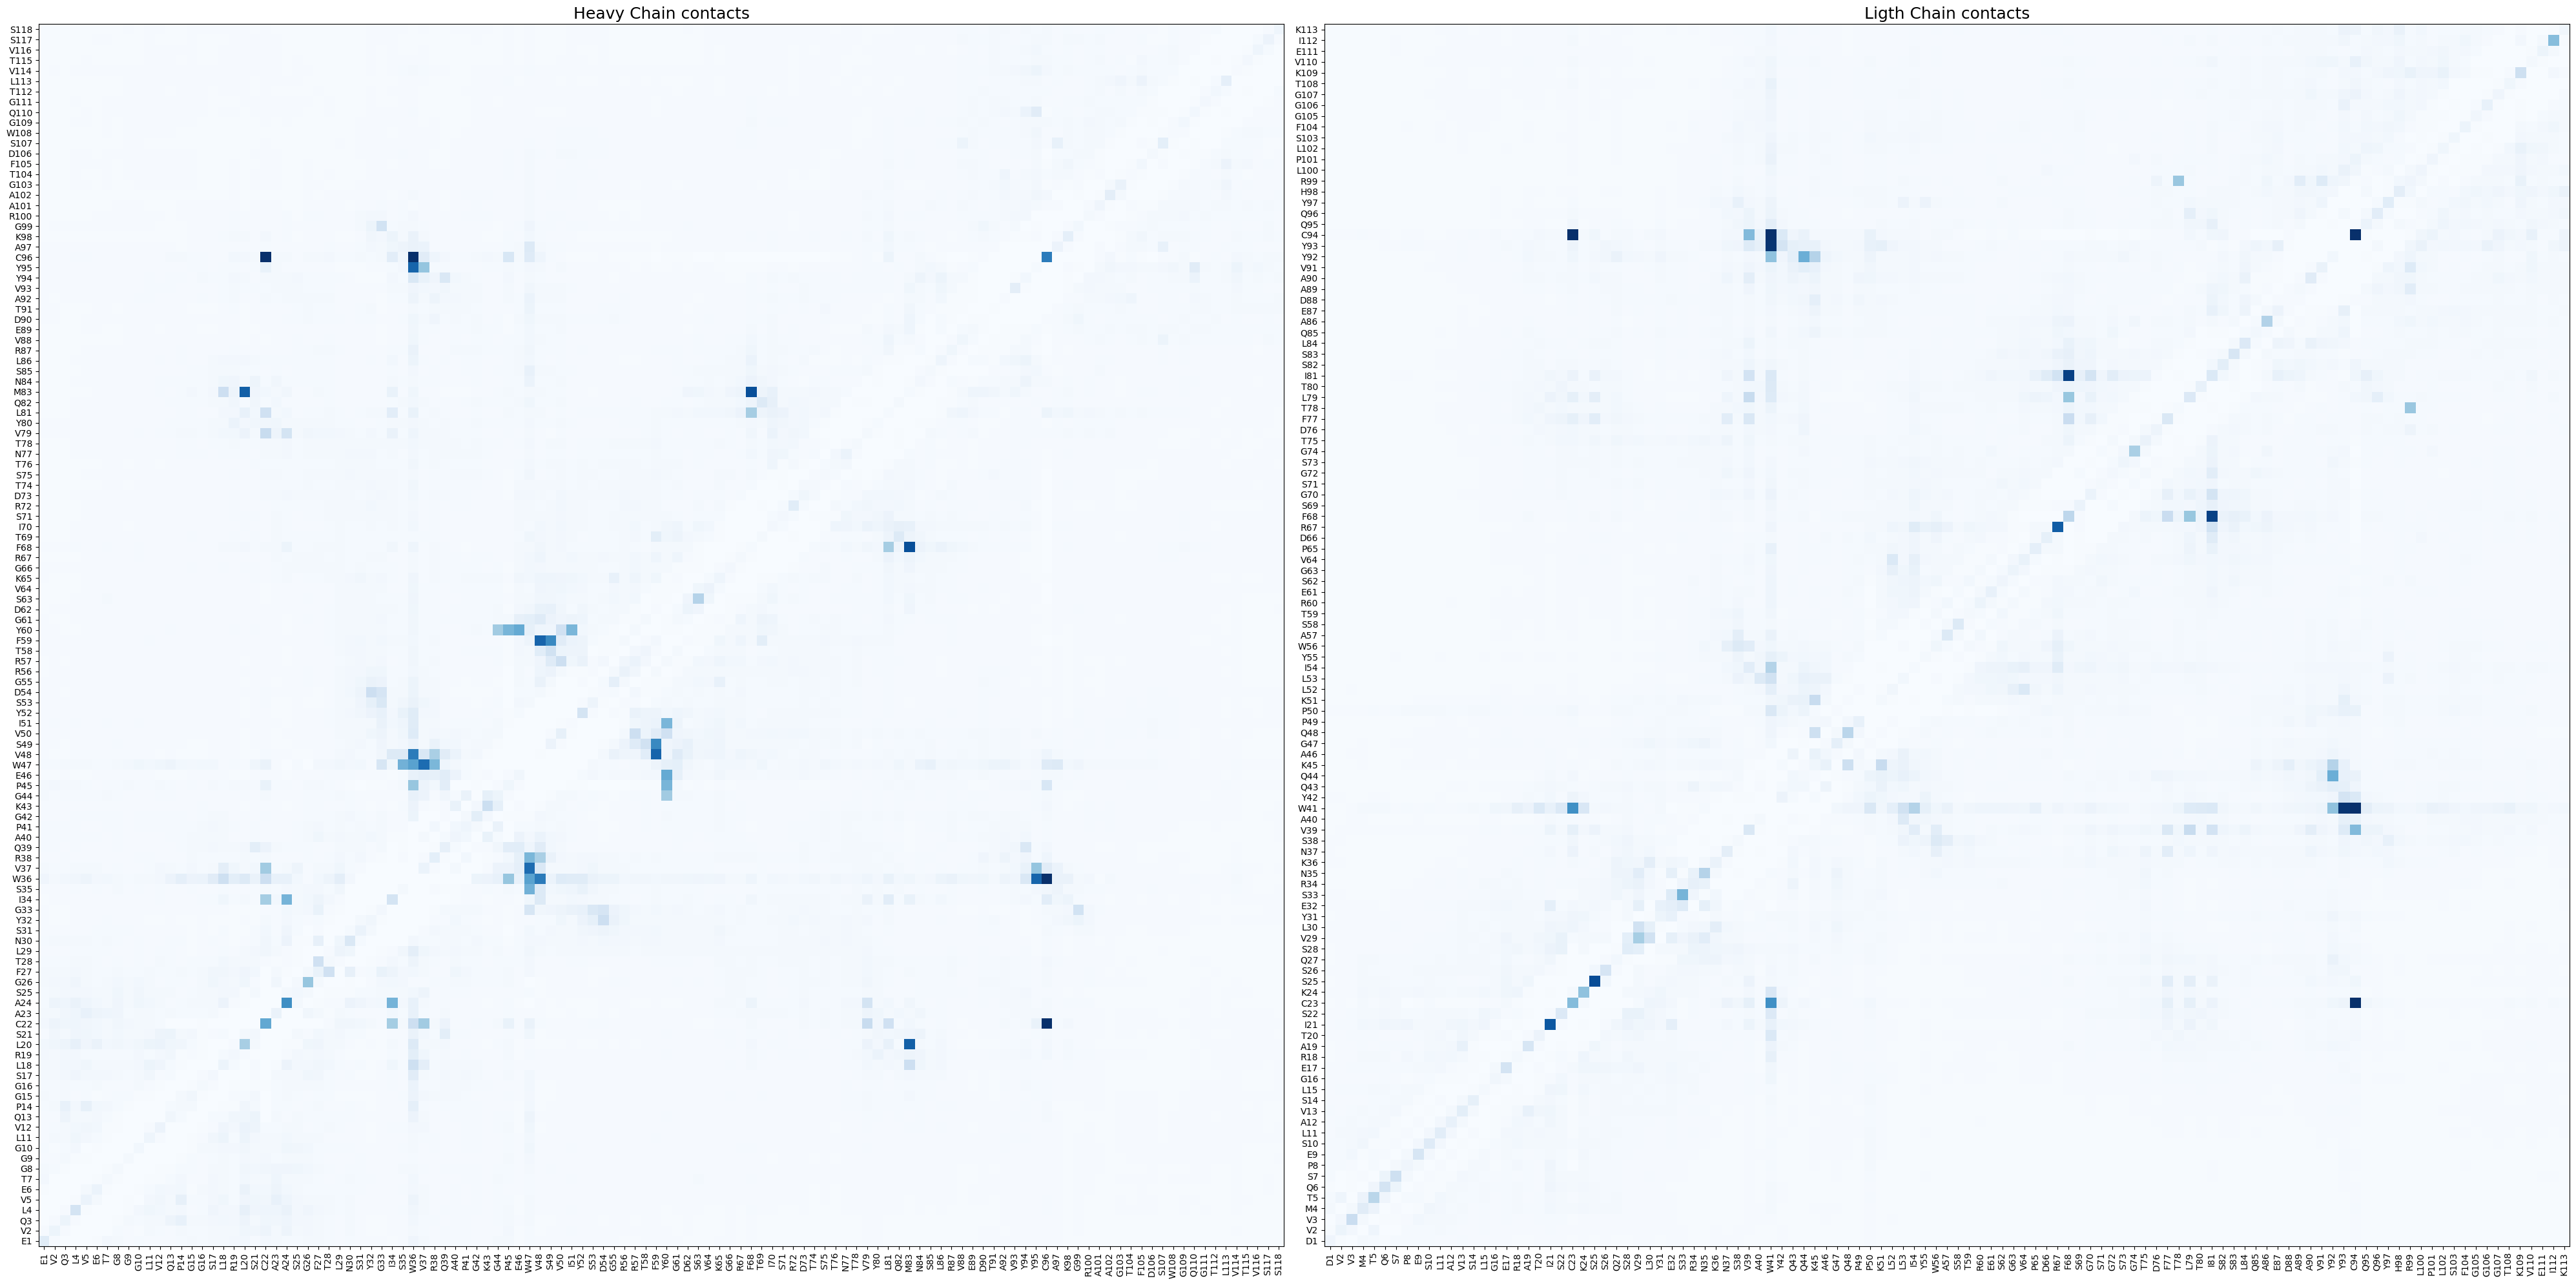

In [9]:
get_contact_for_sequence(model, seed_scFv['14']) 


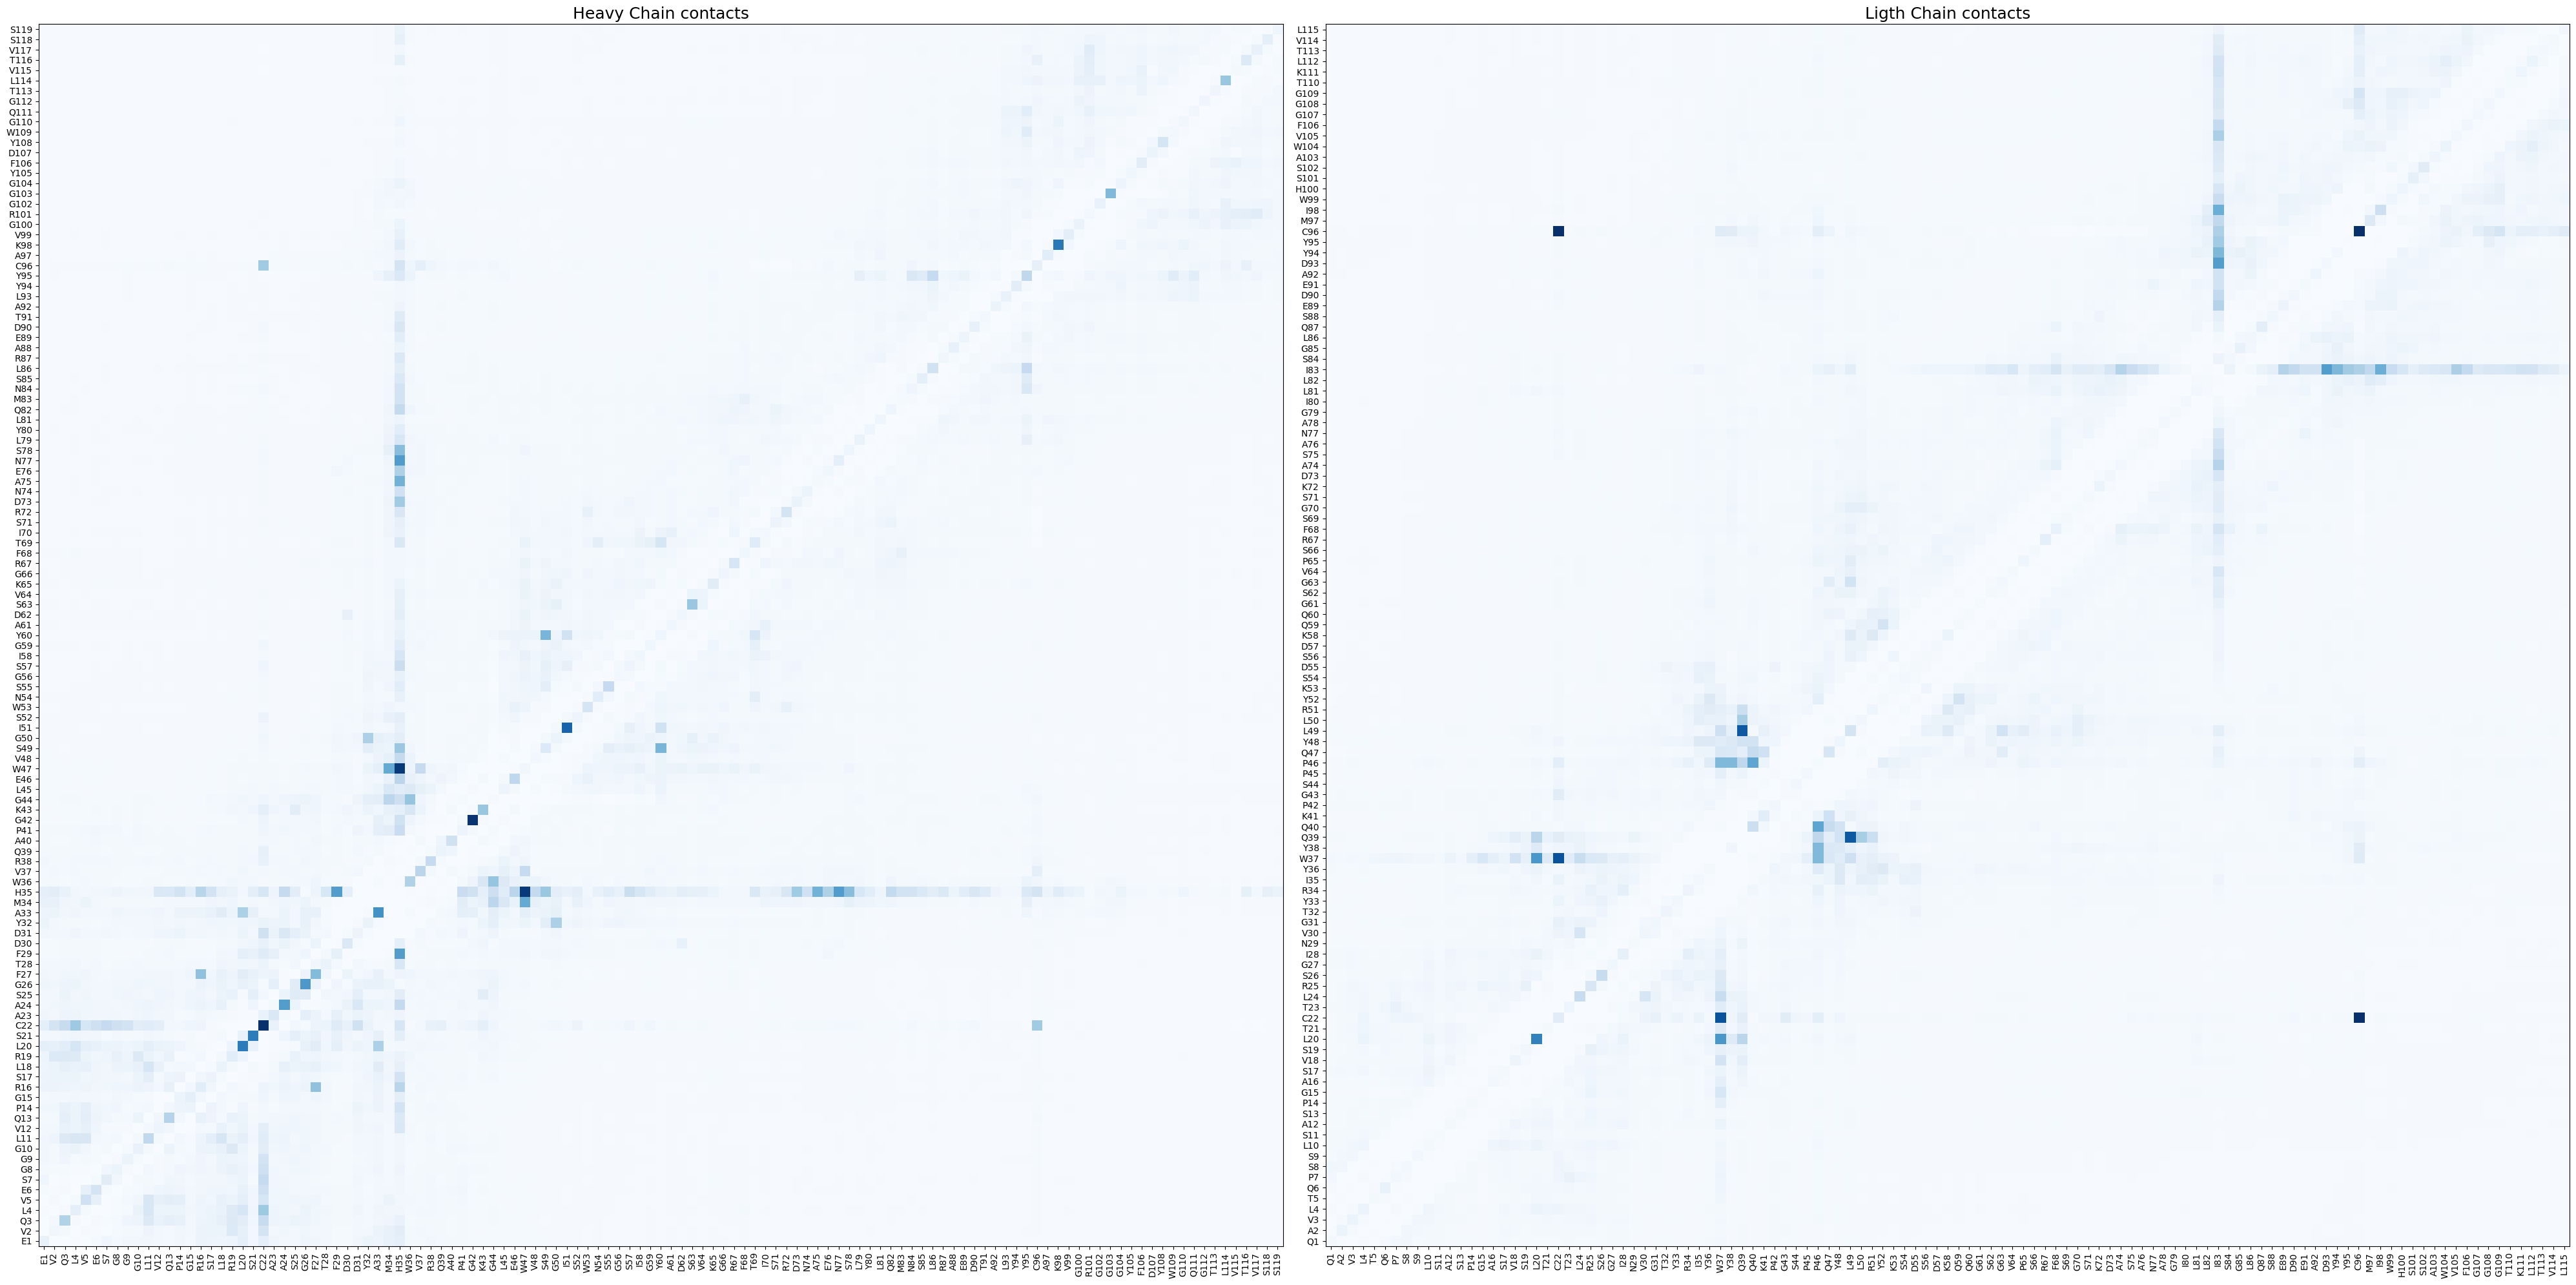

In [10]:
get_contact_for_sequence(model, seed_scFv['91']) 


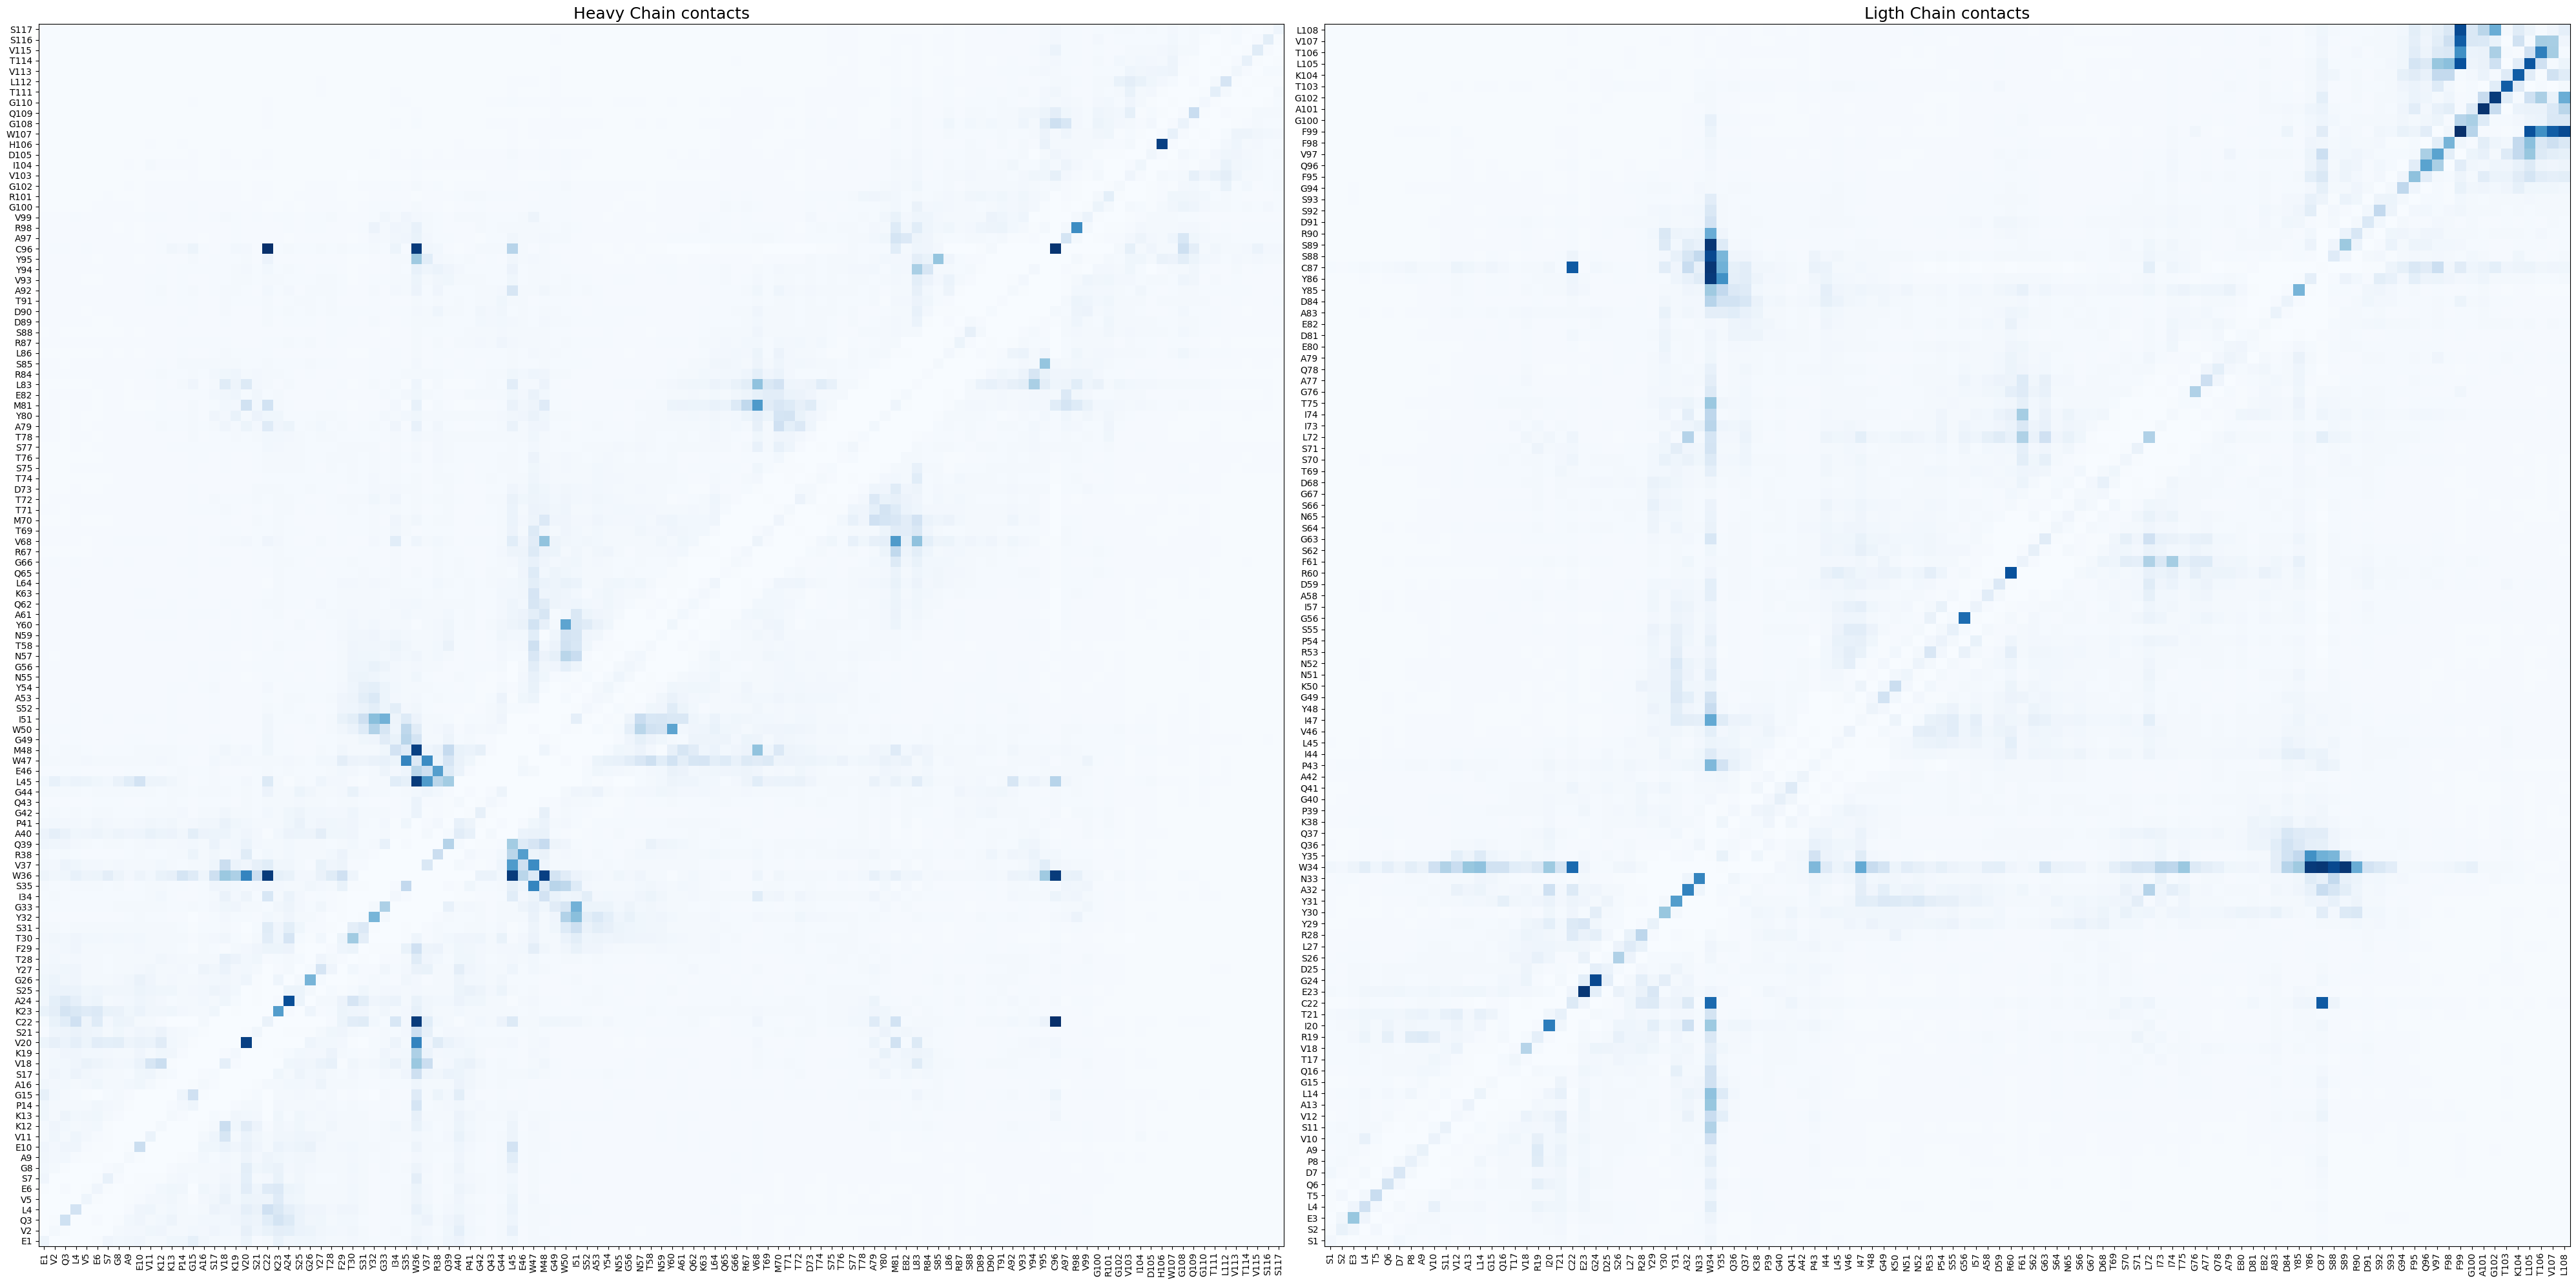

In [11]:
get_contact_for_sequence(model, seed_scFv['95']) 
